In [1]:
import os
import pandas as pd
pd.set_option('display.max_rows', 500)

import datetime as dt
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import re

from collections import Counter

import string
import emoji

import pickle

### Importing whatsapp conversations

In [2]:
# Files must be in txt format (exactly as they are exported from Whatsapp app)
files_individual = os.listdir('data/WhatsApp_txt/individual')
files_groups = os.listdir('data/WhatsApp_txt/groups')

In [3]:
def read_history_individual(file,rows):
    history = pd.read_csv('data/WhatsApp_txt/individual/{}'.format(file),skiprows=rows,sep=':', error_bad_lines = False, header=None).dropna()
    history[0] = history[0] + ":" + history[1].str.split("-",1).apply(lambda x: x[0])
    history[1] = history[1].apply(lambda x: x[5:])
    
    history = history.rename(columns={1:'name',2:'msg'})
    
    history['date1'] = history[0].str.split(",",1).apply(lambda x: x[0])
    history = history[history[0].str.contains(r'[0-9]*/[0-9]*/[0-9]*, [0-9]*:[0-9]* ')]

    history['date'] = pd.to_datetime(history[0],format="%m/%d/%y, %H:%M ")
    history['date1'] = pd.to_datetime(history['date1'],format="%m/%d/%y")
    history['msg_len'] = history['msg'].str.len()
    history['conv_name'] = file[19:-4]
    history['tipo'] = 'i'

    history = history.drop(0,axis=1)

    return history

def read_history_groups(file,rows):
    history = pd.read_csv('data/WhatsApp_txt/groups/{}'.format(file),skiprows=rows,sep=':', error_bad_lines = False, header=None).dropna()
    history[0] = history[0] + ":" + history[1].str.split("-",1).apply(lambda x: x[0])
    history[1] = history[1].apply(lambda x: x[5:])
    
    history = history.rename(columns={1:'name',2:'msg'})
    
    history['date1'] = history[0].str.split(",",1).apply(lambda x: x[0])
    history = history[history[0].str.contains(r'[0-9]*/[0-9]*/[0-9]*, [0-9]*:[0-9]* ')]

    history['date'] = pd.to_datetime(history[0],format="%m/%d/%y, %H:%M ")
    history['date1'] = pd.to_datetime(history['date1'],format="%m/%d/%y")
    history['msg_len']= history['msg'].str.len()
    history['conv_name'] = file[19:-4]
    history['tipo'] = 'g'

    history = history.drop(0,axis=1)

    return history

In [1]:
all = []
# Capturing conversations that cannot be loadaded
unable_individual = []
unable_groups = []

for file in files_individual:
    try:
        history = read_history_individual(file,1)
        all.append(history)
    except:
        try:
            history = read_history_individual(file,3)
            all.append(history)
        except:
            unable_individual.append(file)

for file in files_groups:
    try:
        history = read_history_groups(file,10)
        all.append(history)
    except:
        try:
            history = read_history_groups(file,30)
            all.append(history)
        except:
            try:
                history = read_history_groups(file,40)
                all.append(history)
            except:
                unable_groups.append(file)

In [ ]:
# Conversations that couldn't be loadad
unable_individual + unable_groups

In [ ]:
history = pd.concat(all).reset_index()

In [6]:
# Deleting wrong imports, only 100 values
history = history[history[3].isnull()].drop(3,axis=1)

In [452]:
# Deleting messages with media
history_clean = history[history['msg']!=' <Media omitted>'].sort_values(by=['conv_name','name','date1'])

In [453]:
history_clean.shape

(737366, 8)

In [454]:
# Feature engineering participation rate by conversation

history_clean['year'] = history_clean['date1'].dt.year
history_clean['month'] = history_clean['date1'].dt.month

# Number of messages I sent 
msg_lai = (history_clean[history_clean['name']=='Lai']
           .sort_values(by=['year','month','conv_name'])
           .groupby(['year','month','conv_name'])['name']
           .count()
           .reset_index())

# Total number of messages sent
msg_all = (history_clean
           .sort_values(by=['year','month','conv_name'])
           .groupby(['year','month','conv_name'])
           .agg({'msg': 'count', 'name': pd.Series.nunique})
           .reset_index())

# AVG number of messages sent by person in a conversation
msg_all['avg_msg'] = msg_all['msg'] / msg_all['name']

participation = msg_all.merge(msg_lai,on=['year','month','conv_name'],how='left').fillna(0)
participation['participation'] = participation['name_y'] / participation['avg_msg']
participation = (participation
                 .sort_values(by=['year','month','conv_name'])
                 .rename(columns={'msg':'total_conv_msg','name_x':'conv_participants','name_y':'total_own_msg'}))

history_clean = (history_clean
                 .sort_values(by=['year','month','conv_name'])
                 .merge(participation, on=['year','month','conv_name'], how='left'))

In [456]:
# Importing file with category classification for each conversation (manually made)
# Includes 2 columns: conv_name, category
with open('categories.pkl', 'rb') as picklefile:
    categories = pickle.load(picklefile)

In [458]:
history_clean = history_clean.merge(categories,on='conv_name')

In [461]:
# Exporting history cleaned for processing
with open('history_clean.pkl', 'wb') as picklefile:
    pickle.dump(history_clean, picklefile)

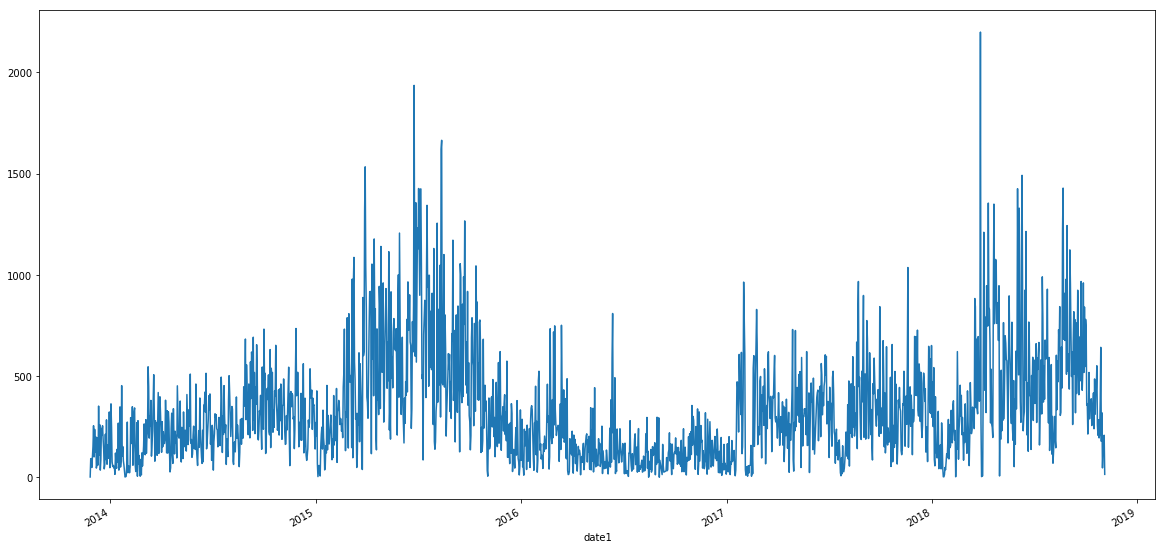

In [206]:
# Number of messages over the years
plt.figure(figsize=(20,10))

history.groupby(['date1']).count()['msg'].plot()

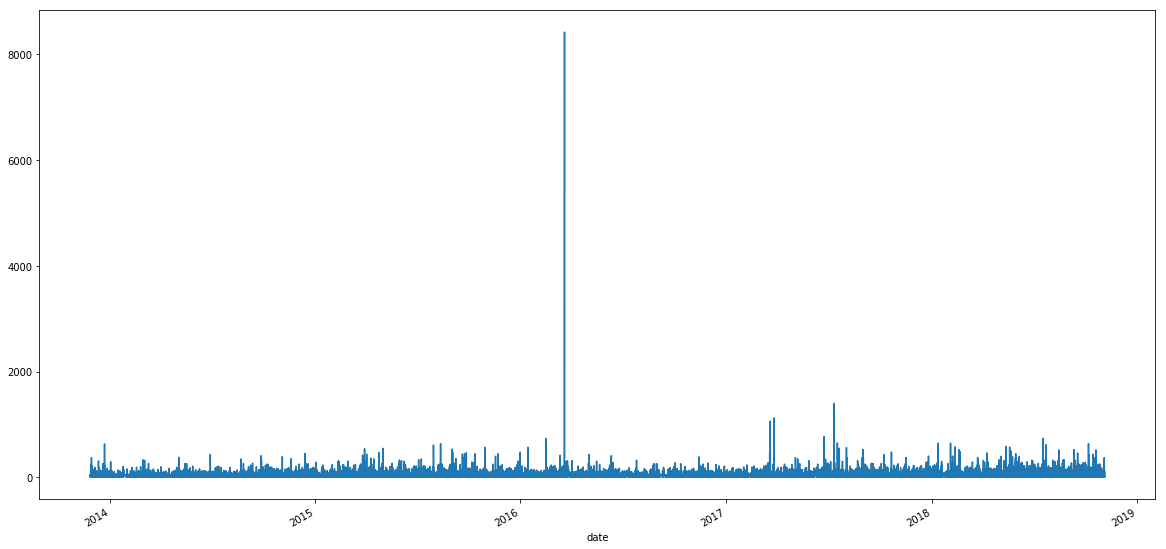

In [207]:
# Length of messages over the years
plt.figure(figsize=(20,10))

history.groupby(['date'])['msg_len'].mean().plot()

In [218]:
# Understanding the message outlier
history[history['msg_len'] == history['msg_len'].max()]['msg'].values

array([' FELIZ CUMPLEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEÈEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEÈEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEÈEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEÈEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEÈEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEÈEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEÈEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEÈEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEÈEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEÈEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEÈEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEÈEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEÈEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEÈEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEÈEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEÈEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEÈEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEÈEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEÈEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEÈEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEÈEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEÈEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEÈEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEÈEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEÈEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE

## Emojis

In [11]:
# Counting number of emojis
def extract_emojis(str):
    return ''.join(c for c in str if c in emoji.UNICODE_EMOJI)

def Count_Emojis(df):
    series = df['msg']
    all_words = ""
    for sentence in series:
        all_words += extract_emojis(sentence)
    word_count = Counter(all_words)
    
    
    ordered = {}
    ordered['msg'] = []
    for key, number in word_count.most_common()[:50]:
        ordered[key] = []
    
    for sentence in series:
        sentence_count = Counter(extract_emojis(sentence))
        
        for word in ordered:
            count = sentence_count[word] if sentence_count[word] else 0
            ordered[word] += [count]
    ordered['msg'] = list(series)
    ordered['date'] = list(df['date'])
    ordered['date1'] = list(df['date1'])
    ordered['name'] = list(df['name'])
    ordered['conv_name'] = list(df['conv_name'])
    
    return pd.DataFrame(ordered)

In [463]:
# Counting emojis by message (limited to top50)
emojis_counts = Count_Emojis(history_clean)

In [469]:
emojis_counts.head(1)

,msg,❤,😍,😁,😱,👏,😂,😘,😜,👌,...,🔫,👆,😧,😴,😋,😩,date,date1,name,conv_name
318,👌,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,2014-11-25 07:31:00,2014-11-25,Alinchu,Alinchu copy


In [31]:
# Removing messages for Tableau Visualization
emojis_counts.drop('msg',axis=1).to_csv('emojis_counts_top50.csv')
pd.melt(emojis_counts.drop('msg',axis=1), id_vars=['conv_name','name','date','date1'], var_name='Emojis').to_csv('emojis_counts_top50_melt2.csv')